# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import ESN
from esn_dts import ESN, Tikhonov

import datetime
from matplotlib.dates import date2num
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.bottom'] = 'True'
plt.rcParams['ytick.left'] = 'True'

# ESN prediction

ESN prediction for temperature data. For three different observed data in the latitudinal direction. Actual data and model prediction are plotted and NRMSE are printed for each case.

In [2]:
# import data for target city 
predict_year = 2021
year_list = list(range(predict_year,predict_year-6,-1))

print("data_list:",year_list)

for i in range(len(year_list)):
    print("loading data of", year_list[i])
    data = pd.read_csv('data/{}/tokyo/data/temp_tokyo_{}.csv'.format(year_list[i],year_list[i]))
    leap_day = []
    for j in range(data.iloc[:,1].size):                                 
        if '-02-29_' in data.iloc[j,0]:                                  
            leap_day.append(j)
    if len(leap_day)!=0:
        print("index of leap day:", leap_day)
    data = data.drop(leap_day) 
    if i==0:
        date_arr = data.iloc[:,0]
        temp_tokyo = data.iloc[:,1]
    else:                                      
        date_arr = np.vstack([date_arr,data.iloc[:,0]])
        temp_tokyo = np.vstack([temp_tokyo,data.iloc[:,1]])
print(date_arr.shape,temp_tokyo.shape)

data_list: [2021, 2020, 2019, 2018, 2017, 2016]
loading data of 2021
loading data of 2020
index of leap day: [236, 237, 238, 239]
loading data of 2019
loading data of 2018
loading data of 2017
loading data of 2016
index of leap day: [236, 237, 238, 239]
(6, 1460) (6, 1460)


input:N36
[dim, RMSE, NRMSE]
[0, 1.965212339878259, 0.21485983311156437]
[1, 1.8537682364855048, 0.2143098653251896]
input:N38
[dim, RMSE, NRMSE]
[0, 1.4396368351607924, 0.1834786858091349]
[1, 2.607961962769559, 0.3015004605289728]
input:N55
[dim, RMSE, NRMSE]
[0, 2.1298776535683426, 0.1561632436216068]
[1, 3.3818825246626134, 0.39097162964671617]


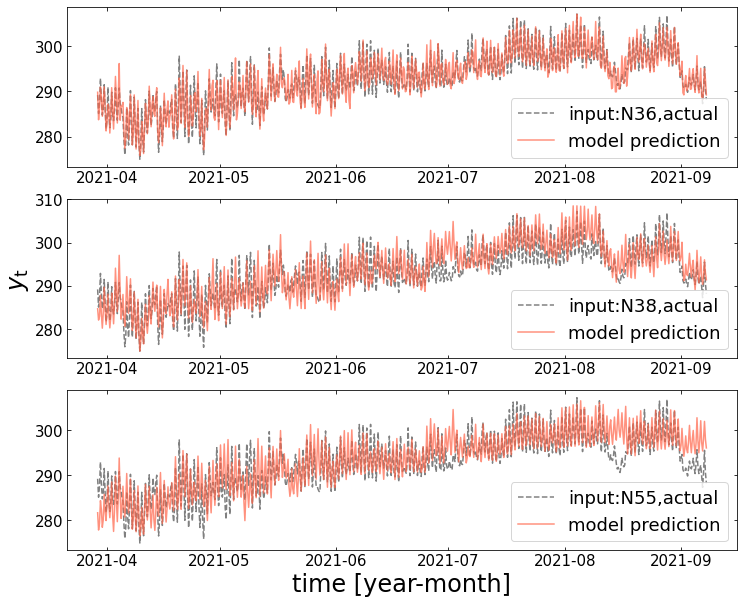

In [3]:
# input loop

lat_list = [36,38,55] #latitudes of observation points (input)

plot_start = 350
plot_end = 1000

# if __name__ == '__main__':

# time setting
dt = 6 # fixed
tau = 1
NRMSE_list = []

fig = plt.figure(figsize=(12, 10), facecolor="w")
rows, cols = 3,1

for l in range(len(lat_list)):
    for i in range(len(year_list)):
        data = pd.read_csv('reanalysis_data/JRA-55_6-Hourly_Model_Resolution_Surface_Analysis_Fields/{0}/tokyo/data/temp_lat{1}-{2}_lon139-140_{0}.csv'.format(year_list[i],lat_list[l],lat_list[l]+1))
        leap_day = []
        for j in range(data.iloc[:,1].size):                                 
            if '-02-29_' in data.iloc[j,0]:                                  
                leap_day.append(j)                   
        data = data.drop(leap_day) # drop leap_day
        if i==0:
            temp_data = data.iloc[:,1]
        else:
            temp_data = np.vstack([temp_data,data.iloc[:,1]])

    T_test = date_arr[0,:].size # 1-year
    T_trans = 300
    data_time = np.append(np.append(date_arr[2,-T_trans:],date_arr[1,:]),date_arr[0,:T_test])
#     print(date_arr[0,:T_test],date_arr[0,:],date_arr[2,-T_trans:].size)
    T0 = data_time.size # T_trans + T_train + T_test (3220)
    T = T0-tau-T_trans
#         print(T0,T_test,T_trans)

    # make dataset of the target point
    ave_tokyo = np.average([np.append(np.append(temp_tokyo[5,-T_trans:],temp_tokyo[4,:]),temp_tokyo[3,:T_test]),
                            np.append(np.append(temp_tokyo[4,-T_trans:],temp_tokyo[3,:]),temp_tokyo[2,:T_test]),
                            np.append(np.append(temp_tokyo[3,-T_trans:],temp_tokyo[2,:]),temp_tokyo[1,:T_test])],axis=0)
    diff_tokyo = np.append(np.append(temp_tokyo[2,-T_trans:],temp_tokyo[1,:]),temp_tokyo[0,:T_test]) - ave_tokyo
    # make dataset of a observation point
    ave_data = np.average([np.append(np.append(temp_data[5,-T_trans:],temp_data[4,:]),temp_data[3,:T_test]),
                            np.append(np.append(temp_data[4,-T_trans:],temp_data[3,:]),temp_data[2,:T_test]),
                            np.append(np.append(temp_data[3,-T_trans:],temp_data[2,:]),temp_data[1,:T_test])],axis=0)
    diff_data = np.append(np.append(temp_data[2,-T_trans:],temp_data[1,:]),temp_data[0,:T_test]) - ave_data


    date_data = np.append(np.append(date_arr[2,-T_trans:],date_arr[1,:]),date_arr[0,:T_test])
    ymdh = [datetime.datetime.strptime(x, '%Y-%m-%d_%H') for x in date_data]


    ave = np.vstack((ave_data,ave_tokyo))
    ave = ave.T
#         print("ave_shape:", ave.shape)

    u0 = diff_data # input
    u0 = u0.reshape(1, -1)
    d0 = np.vstack((diff_data,diff_tokyo)) # output

    # data after transient period
    u = u0[:, T_trans:T_trans+T]
    d = d0[:, T_trans+tau:T_trans+tau+T]
    T_train = T - T_test
    # data for training and testing
    train_U = u[:, :T_train].T
    train_D = d[:, :T_train].T
    test_U = u[:, T_train:].T
    test_D = d[:, T_train:].T

    test_time = ymdh[-T_test:]

#     print('(train_U.shape, train_D.shape, test_U.shape, test_D.shape)=',train_U.shape, train_D.shape, test_U.shape, test_D.shape)

    # fixed parameters
    N_x = 400 # reservoir size
    # default
    density = 0.02  # connection density d 0.02
    input_scale = 0.2  # input scaling (gamma) 0.2
    rho = 0.5  # spectral radius rho 0.5
    beta = 1.0  # regularization factor 1.0

    # leak rate (default: scale_max=scale_min=0 (normal ESN))
    scale_max = 0
    scale_min = 0
    power = scale_min + (scale_max-scale_min)*np.random.rand(N_x)
    base = np.ones(N_x)*10.0
    leaking_rate = [a ** b for (a, b) in zip(base, power)]
    leaking_rate.sort()
    # print(leaking_rate)

    model = ESN(train_U.shape[1], train_D.shape[1], N_x,
                density, input_scale, rho, leaking_rate=np.array(leaking_rate),seed=0)

    # ridge regression
    train_Y = model.train(train_U, train_D, Tikhonov(train_U.shape[1], N_x, train_D.shape[1], beta))
    #
    # prediction
    test_Y = model.predict(test_U)            
    # evaluation
    print('input:N{}'.format(lat_list[l]))
    print('[dim, RMSE, NRMSE]')
    for k in range(test_Y.shape[1]):
        RMSE = np.sqrt((((test_D[:,k]+ave[-T_test:,k]) - (test_Y[:,k]+ave[-T_test:,k])) ** 2).mean())
        NRMSE = RMSE/np.sqrt(np.var(test_D[:,k]+ave[-T_test:,k]))
        print([k, RMSE, NRMSE])

    ax = fig.add_subplot(rows, cols, l+1)
    ax.tick_params(labelsize=15)

    # plot whole test data
#         ax.plot(test_time,test_D[:,1]+ave[-T_test:,1], "--", color="gray", label='input:N{},actual'.format(lat_list[l]))
#         ax.plot(test_time,test_Y[:,1]+ave[-T_test:,1], "-", color="tomato", label='model prediction',alpha=0.7)
    # plot a part of test data
    ax.plot(test_time[plot_start:plot_end],(test_D[:,1]+ave[-T_test:,1])[plot_start:plot_end], "--", color="gray", label='input:N{},actual'.format(lat_list[l]))
    ax.plot(test_time[plot_start:plot_end],(test_Y[:,1]+ave[-T_test:,1])[plot_start:plot_end], "-", color="tomato", label='model prediction',alpha=0.7)
    plt.legend(loc=4,fontsize=18)
    if (l==1):
        plt.ylabel(r"$y_\mathrm{t}$", fontsize=24)
plt.xlabel("time [year-month]", fontsize=24)
plt.show()